#  Tobacco area classification for Malawi

# Import required libraries

In [1]:
import sentinelsat
from sentinelsat import SentinelAPI
import geopandas as gpd
from osgeo import gdal
import georaster
import rasterio
import rasterio as rio
from rasterio import mask as msk
from rasterio import plot
from rasterio.plot import show
import folium 
import shapely
from shapely.geometry import MultiPolygon, Polygon
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt

import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mc

import earthpy.plot as ep
from matplotlib.colors import ListedColormap


from sklearn import cluster
import numpy as np

import random

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Accessing data

 we need to register a username in [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and note down your username and password and paste them here inside the code.

In [6]:
user = "Marcinclair" 
password = "Marcinclair" 
api = SentinelAPI(user, password, "https://scihub.copernicus.eu/dhus")

# Display the shapefile data as a map

In [7]:
def display_map(file, latitude, longitude):
    
    # latitude and logitude range for Malawi 
    # [-15.786111, 35.005833] --> center
    range_latitude_Malw = [-17, -9]
    range_longitude_Malw = [33, 36]
    
    # latitude and logitude range for Mozambique
    # [-13.2512161, 34.3015278] --> center
    range_latitude_Moz = [-26, -10]
    range_longitude_Moz = [32, 41]
    
    while (True):
        Country_Name = input("Enter the name of your chosen country : Malawi or Mozambique\n\n")
        if (Country_Name != "Malawi" and Country_Name != "Mozambique"):
            print("Country name don't match. Try the exact name: Malawi or Mozambique")
        else:
            if Country_Name == "Malawi":
                if ( range_latitude_Malw[0] <= latitude <= range_latitude_Malw[1] and range_longitude_Malw[0] <= longitude <= range_longitude_Malw[1]):
                    pass
                else:
                    raise ValueError("Your latitude or longitude don't match! Please try again.")

            elif Country_Name == "Mozambique":
                if ( range_latitude_Moz[0] <= latitude <= range_latitude_Moz[1] and range_longitude_Moz[0] <= longitude <= range_longitude_Moz[1]):
                    pass
                else:
                    raise ValueError("Your latitude or longitude don't match! Please try again.")
            
            M = folium.Map([latitude, longitude], zoom_start=5)
            folium.GeoJson(file).add_to(M)
            return M

In [8]:
#shapefile_Mozam_data1 = gpd.read_file("ShapeMozambique/MOZ_adm1.shp")

bounds_geojson = gpd.read_file("C:/Users/engelbert/Downloads/Ishango/Notebook/mapMalawi.geojson")

# latitudeMozan = -18.665695
# longitudeMozan = 35.529562

latitudeMalw = -13.9621
longitudeMalw = 33.7937

display_map(bounds_geojson, latitudeMalw, longitudeMalw)

Enter the name of your chosen country : Malawi or Mozambique

Malawi


In [9]:
# search by polygon

path_geojson_file = "C:/Users/engelbert/Downloads/Ishango/Notebook/mapMalawi.geojson"

footprint = geojson_to_wkt(read_geojson(path_geojson_file))

print (footprint)

GEOMETRYCOLLECTION(POLYGON((35.0024 -16.5941,35.3540 -16.1725,35.7056 -16.0247,35.7935 -15.6654,35.7715 -15.1782,35.8813 -14.8174,35.6836 -14.4772,35.3101 -14.1792,34.8047 -14.3070,34.5850 -14.2005,34.4971 -13.8594,34.2993 -13.4324,34.1675 -12.6618,33.9917 -12.1467,34.1675 -11.7813,34.2114 -11.2862,34.1455 -10.5526,33.9917 -10.3149,33.7939 -10.5526,33.4644 -11.0059,33.3545 -11.4585,33.3325 -11.9963,33.4424 -12.2541,33.5303 -12.4258,33.0688 -12.7689,33.0688 -13.0046,32.8052 -13.6673,33.1348 -13.9021,33.3984 -14.1792,33.7280 -14.4985,34.3652 -14.3495,34.5410 -14.5198,34.6509 -15.0085,34.3872 -15.9402,35.0024 -16.5941)))


## Searching products

In [10]:
products = api.query(footprint,
                     date = ('20190901', '20210430'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0, 60)
                    )

Querying products:   4%|3         | 100/2824 [00:00<?, ?product/s]

In [11]:
print(f"The number of products are : {len(products)}")

The number of products are : 2824


In [12]:
products_gdf = api.to_geodataframe(products)
products_gdf.head(2)

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry
15bda0d3-cec3-4254-9c0a-4e7133f9530d,S2A_MSIL2A_20210428T073611_N0300_R092_T36LWJ_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-04-28T07:36:11.024Z, Instrument: MS...",false,2021-04-28 10:12:06,2021-04-28 07:36:11.024,2021-04-28 07:36:11.024,2021-04-28 13:22:55.572,...,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS1_20210428T101206_S2021...,S2A_OPER_MSI_L2A_TL_VGS1_20210428T101206_A0305...,S2A_MSIL2A_20210428T073611_N0300_R092_T36LWJ_2...,15bda0d3-cec3-4254-9c0a-4e7133f9530d,"MULTIPOLYGON (((32.99981 -15.46502, 34.02332 -..."
0b1e08fb-56ea-45ff-8d0d-8fea730744a4,S2A_MSIL2A_20210428T073611_N0300_R092_T36LYH_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-04-28T07:36:11.024Z, Instrument: MS...",false,2021-04-28 10:12:06,2021-04-28 07:36:11.024,2021-04-28 07:36:11.024,2021-04-28 13:22:52.863,...,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS1_20210428T101206_S2021...,S2A_OPER_MSI_L2A_TL_VGS1_20210428T101206_A0305...,S2A_MSIL2A_20210428T073611_N0300_R092_T36LYH_2...,0b1e08fb-56ea-45ff-8d0d-8fea730744a4,"MULTIPOLYGON (((34.87205 -16.36093, 35.27488 -..."


# Downloading data

In [13]:
# This function take as input a path for the geoson file, started and ended date for the tobacco crop,
# print the number of ID products, check if the products ID is available online,
# print he number of products ID available online, download the data for a random particular ID

def Download_Random_ProductID_Sentinel2_Data(path_geojson_file, start_date, end_date):
    
    cpt = 0
    lis_of_index_products_online = []
    
    # Search by polygon
    footprint = geojson_to_wkt(read_geojson(path_geojson_file))
    
    # Searching products
    products = api.query(footprint,
                     date = (start_date, end_date),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = cloudcoverpercentage
                    )
    
    # Convert the result into pandas
    products_gdf = api.to_geodataframe(products)
    
    # Print the number of the products ID
    print(f"The number of products are : {len(products_gdf['uuid'])}")
    
    # go over the number of products
    for i in range(len(products_gdf['uuid'])):
        
        # get each ID products which is a dictionnary
        product_id = api.get_product_odata(products_gdf['uuid'][i])
        
        # go over the keys and get the values
        for j in product_id.keys():
            if (j == 'Online' and product_id[j] == True):
                
                # put the index of product available online  in the list
                lis_of_index_products_online.append(i)
                    
                # print the index and ID of available product online
                print(f"For the index = {i} , the product with ID = {products_gdf['uuid'][i]} is online")
            
                # count the number of product available online
                cpt += 1
    
    # print the list of the index available products online
    print()
    print(f"The list of the available index product online is : {lis_of_index_products_online}")
    print('----'*10)
    print()
    print(f"The number of available products online are : {cpt}")
    
    # check if the list is empty
    if len(lis_of_index_products_online) == 0:
        
        raise ValueError("You can't proceed to the download now because there is no product available online at the moment.")
    
    else:
        
        # Downloading for a particular ID randomly from the list of index
        choice_index_product_random = random.choice(lis_of_index_products_online)
        api.download(products_gdf['uuid'][choice_index_product_random])

In [14]:
# This function take as input a path for the geoson file, started and ended date for the tobacco crop,
# print the number of ID products, check if the products ID is available online,
# print he number of products ID available online, download all the data for all available ID

def Download_All_ProductID_Sentinel2_Data(path_geojson_file, start_date, end_date):
    
    cpt = 0
    lis_of_index_products_online = []
    
    # Search by polygon
    footprint = geojson_to_wkt(read_geojson(path_geojson_file))
    
    # Searching products
    products = api.query(footprint,
                     date = (start_date, end_date),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = cloudcoverpercentage
                    )
    
    # Convert the result into pandas
    products_gdf = api.to_geodataframe(products)
    
    # Print the number of the products ID
    print(f"The number of products are : {len(products_gdf['uuid'])}")
    
    # go over the number of products
    for i in range(len(products_gdf['uuid'])):
        
        # get each ID products which is a dictionnary
        product_id = api.get_product_odata(products_gdf['uuid'][i])
        
        # go over the keys and get the values
        for j in product_id.keys():
            if (j == 'Online' and product_id[j] == True):
                
                # put the index of product available online  in the list
                lis_of_index_products_online.append(i)
                    
                # print the index and ID of available product online
                print(f"For the index = {i} , the product with ID = {products_gdf['uuid'][i]} is online")
            
                # count the number of product available online
                cpt += 1
    
    # print the list of the index available products online
    print()
    print(f"The list of the available index product online is : {lis_of_index_products_online}")
    print('----'*10)
    print()
    print(f"The number of available products online are : {cpt}")
    
    for k in range(len(lis_of_index_products_online)):
    
        # check if the list is empty
        if len(lis_of_index_products_online) == 0:

            raise ValueError("You can't proceed to the download now because there is no product available online at the moment.")

        else:

            # Downloading all the available product from the list of index
            api.download(products_gdf['uuid'][k])

In [19]:
path_geojson_file = "C:/Users/engelbert/Downloads/Ishango/Notebook/mapMalawi.geojson"
start_date = '20200901'
end_date = '20210430'
cloudcoverpercentage = (0,60)


# Download a particular random products
Download_Random_ProductID_Sentinel2_Data(path_geojson_file, start_date, end_date)

# # Download all the available products
# Download_All_ProductID_Sentinel2_Data(path_geojson_file, start_date, end_date)

Querying products:  10%|9         | 100/1039 [00:00<?, ?product/s]

The number of products are : 1039
For the index = 8 , the product with ID = 82c1fb28-c566-409a-858c-3287afd820f4 is online
For the index = 10 , the product with ID = 06ede752-2fb5-427f-b3fe-fd669cc9fcc1 is online
For the index = 33 , the product with ID = 734a0372-6c5b-463f-8604-cd25eb3cb651 is online
For the index = 36 , the product with ID = 265835c3-b27d-4745-9a91-87fab68e0196 is online
For the index = 51 , the product with ID = ec11648d-1a20-4a95-82f1-2924aaba17b5 is online
For the index = 58 , the product with ID = a473a3be-3755-4797-863f-19670898d86d is online
For the index = 86 , the product with ID = 20c2c79c-b4d4-491d-99f7-2611b28da473 is online
For the index = 559 , the product with ID = f4469737-bae5-4a1a-bfda-ab3790e1e467 is online

The list of the available index product online is : [8, 10, 33, 36, 51, 58, 86, 559]
----------------------------------------

The number of available products online are : 8


MD5 checksumming:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

## Unzip sentinel 2 data

In [20]:
path_to_zip = './S2B_MSIL2A_20201114T074159_N0214_R092_T36LWL_20201114T100911.zip'
path_to_extract_to = './'

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(path_to_extract_to)

# Create RGB Image

The true color of satellite images is often displayed in a combination of the red, green and blue bands. Let us first read the data with Rasterio and create an RGB image from Bands 4, 3, and 2.

Our sensor is capable of capturing for different multispectral bands including **red, green, blue** and **near-infrared (nir)** with resolution of 10 to 60 meters.

In [2]:
# Open Bands 4, 3 and 2 with Rasterio

"""
First, we open an empty RGB.tiff in Rasterio with the same parameters — i.e. width, height, CRS, etc..
— of Band 4 ( You can choose any of the three bands). Then we need to write those bands to the empty RGB image.
"""


path = 'C:/Users/engelbert/Downloads/Ishango/Notebook/S2B_MSIL2A_20201114T074159_N0214_R092_T36LWL_20201114T100911.SAFE/GRANULE/L2A_T36LWL_A019280_20201114T080247/IMG_DATA/R10m/'
band4 = rasterio.open(path+'T36LWL_20201114T074159_B04_10m.jp2') #red
band3 = rasterio.open(path+'T36LWL_20201114T074159_B03_10m.jp2') #green
band2 = rasterio.open(path+'T36LWL_20201114T074159_B02_10m.jp2') #blue


# Create an RGB image 
with rio.open('RGB_Malw.tiff', 'w', driver='Gtiff', width=band4.width, height=band4.height, 
              count=3, crs=band4.crs, transform=band4.transform, dtype=band4.dtypes[0]) as rgb:
    rgb.write(band2.read(1),1) 
    rgb.write(band3.read(1),2) 
    rgb.write(band4.read(1),3) 
    rgb.close()

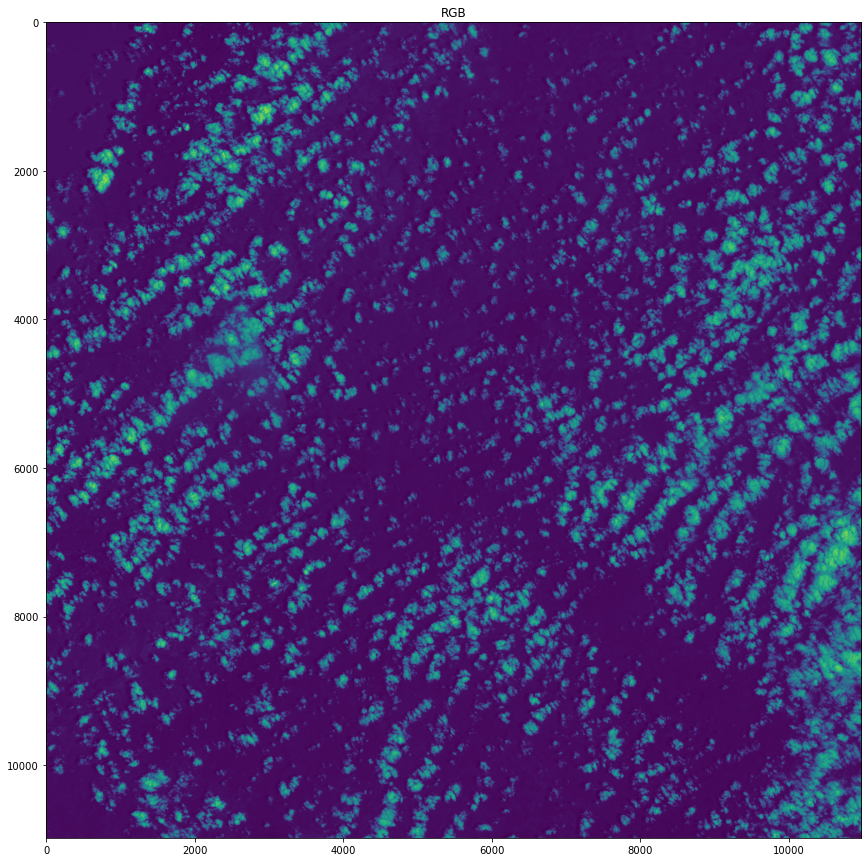

In [22]:
# print the RGB 
image = georaster.SingleBandRaster('C:/Users/engelbert/Downloads/Ishango/Notebook/RGB2.tiff')

plt.figure(figsize = (15,15))
plt.imshow(image.r) 
plt.title('RGB')
plt.show()

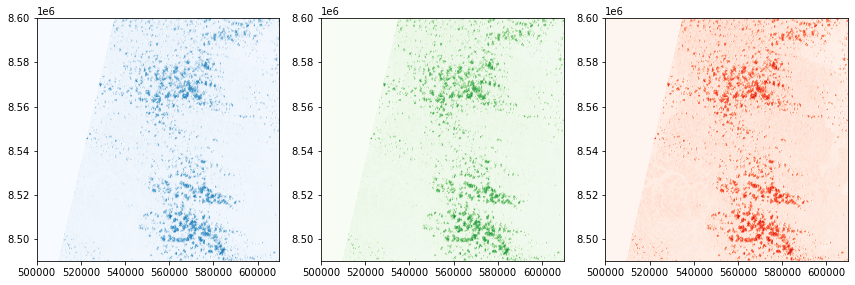

In [23]:
# multiple band representation

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot.show(band2, ax=ax1, cmap='Blues')
plot.show(band3, ax=ax2, cmap='Greens')
plot.show(band4, ax=ax3, cmap='Reds')
fig.tight_layout()

# Create NDVI (Normalized Difference Vegetation Index)

Calculating **NDVI** is an important indicator to assess the presence/absence of green vegetation from the satellite images. To calculate the **NDVI**, you need Red band and Near-Infrared Band **(NIR)**. Different satellite images assign different numbers for these bands. Sentinel Images have red in 4th band and **NIR** in the 8th band. The formula for **NDVI** calculation is:

$$ \mbox{NDVI} = \frac{\mbox{NIR} - \mbox{Red}}{\mbox{NIR} + \mbox{Red}}$$

To carry out this in Rasterio we need first to read the 4th and 8th bands as arrays. We also need to make sure that the arrays are floats.

In [3]:
# Open b4 and b8

path = 'C:/Users/engelbert/Downloads/Ishango/Notebook/S2B_MSIL2A_20201114T074159_N0214_R092_T36LWL_20201114T100911.SAFE/GRANULE/L2A_T36LWL_A019280_20201114T080247/IMG_DATA/R10m/'
band4 = rasterio.open(path+'T36LWL_20201114T074159_B04_10m.jp2')
band8 = rasterio.open(path+'T36LWL_20201114T074159_B08_10m.jp2')


# read Red(b4) and NIR(b8) as arrays
red = band4.read()
nir = band8.read()


# Calculate ndvi = (nir - red)/(nir + red)
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

# Write the NDVI image
meta = band4.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI_Malw.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

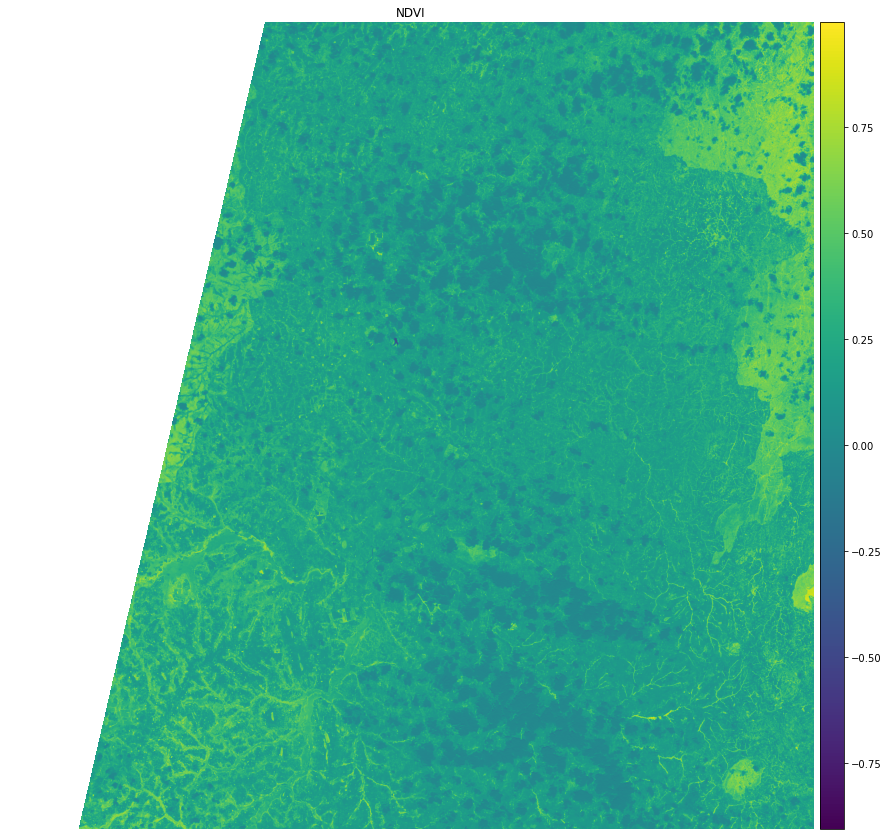

In [25]:
with rio.open('C:/Users/engelbert/Downloads/Ishango/Notebook/NDVI_Malw.tif') as src:
    dem = src.read()
    fig, ax = plt.subplots(figsize = (15, 15))
im = ax.imshow(dem.squeeze())
ep.colorbar(im)
ax.set(title="NDVI")
ax.set_axis_off()
plt.show()

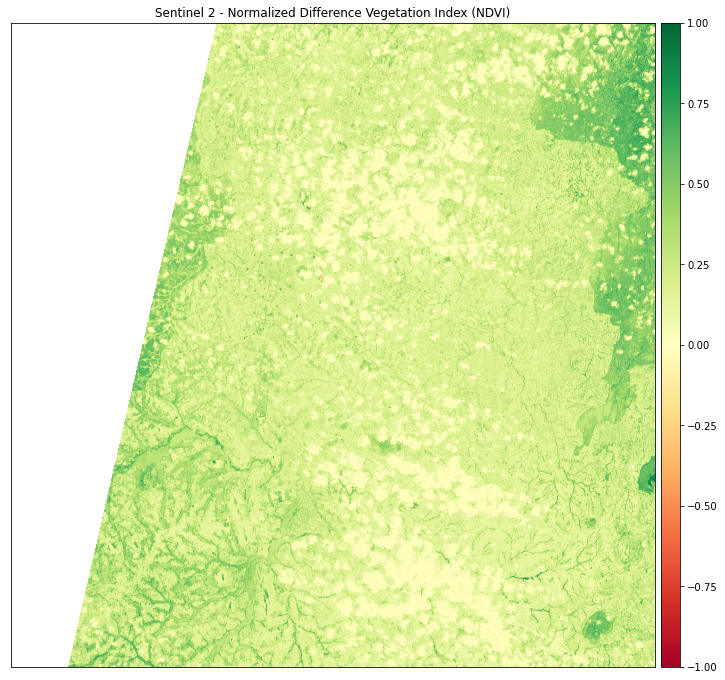

<AxesSubplot:title={'center':'Sentinel 2 - Normalized Difference Vegetation Index (NDVI)'}>

In [4]:
"""
Plot NDVI using EarthPy
"""

titles = ["Sentinel 2 - Normalized Difference Vegetation Index (NDVI)"]

# Turn off bytescale scaling due to float values for NDVI
ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, title=titles, vmin=-1, vmax=1)

## Classify NDVI

In [5]:
# Create classes and apply to NDVI results
ndvi_class_bins = [-np.inf, 0, 0.1, 0.25, 0.4, np.inf]
ndvi_sentinel_class = np.digitize(ndvi, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_sentinel_class = np.ma.masked_where(
    np.ma.getmask(ndvi), ndvi_sentinel_class
)
np.unique(ndvi_sentinel_class)

masked_array(data=[1, 2, 3, 4, 5, 6],
             mask=False,
       fill_value=999999,
            dtype=int64)

## Plot classified NDVI with categorical legend using EarthPy

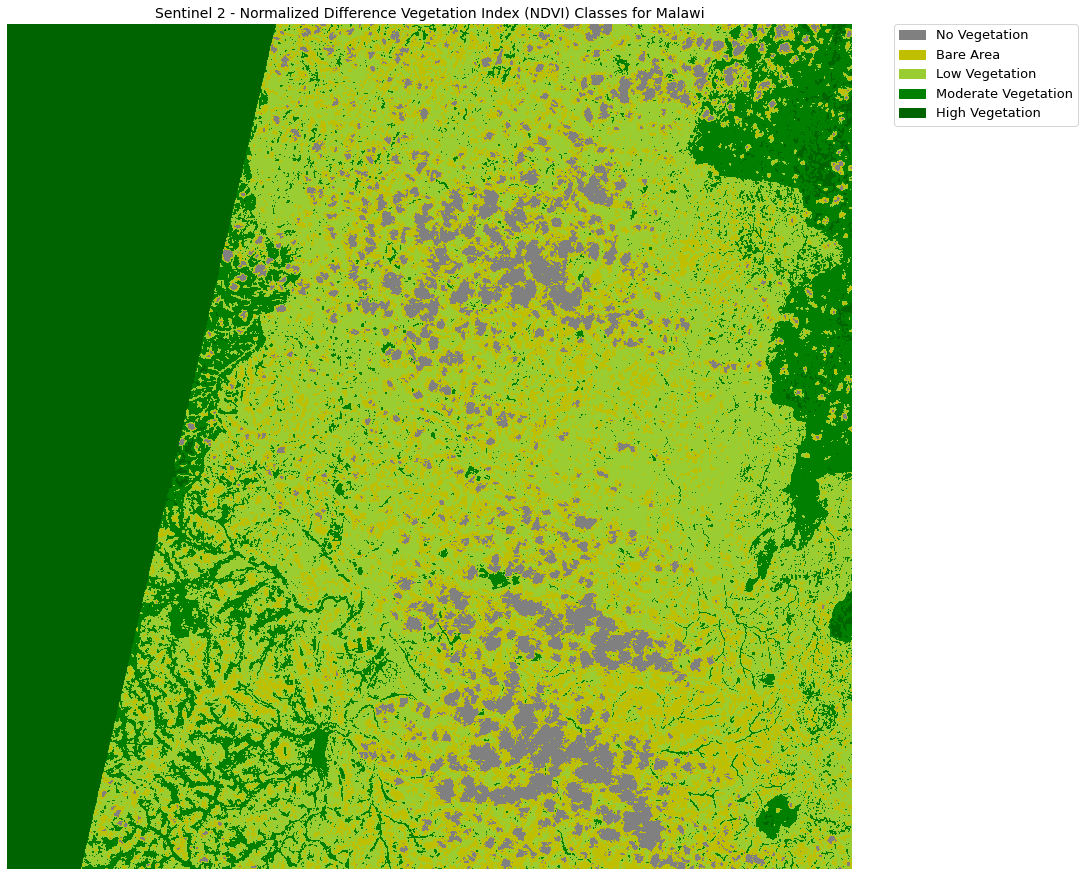

In [6]:
# Define color map
nbr_colors = ["gray", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "No Vegetation",
    "Bare Area",
    "Low Vegetation",
    "Moderate Vegetation",
    "High Vegetation",
]

# Get list of classes
classes = np.unique(ndvi_sentinel_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:5]

# reshape from (1, 10980, 10980) ----> (10980, 10980)
ndvi_sentinel_class = np.squeeze(ndvi_sentinel_class)

# Plot your data
fig, ax = plt.subplots(figsize=(15, 15))
im = ax.imshow(ndvi_sentinel_class, cmap=nbr_cmap)

ep.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)
ax.set_title(
    "Sentinel 2 - Normalized Difference Vegetation Index (NDVI) Classes for Malawi",
    fontsize=14,
)
ax.set_axis_off()

# Auto adjust subplot to fit figure size
plt.tight_layout()